### Training Mask-RCNN for mice segmentation
This notebook presents the workflow for training a new Mask-RCNN model to segment mice
1. Data preparation   
2. Training Mask RCNN

In [1]:
import os
import sys
import numpy as np

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from imgaug import augmenters as iaa
from mouse.utils import video2frames, background_subtraction, split_train_val, create_dataset
from mouse.mouse import MouseConfig, MouseDataset

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "mrcnn_models")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"mrcnn_models", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    

C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,

### 1. Data preparation
Data for training can be grabbed from a video or a directory containing a sequence of frames

In [3]:
bg_dir = '..\\videos\\BG1.jpg'            #----- Path to cage background which is normally imaged before the experiment

In [4]:
# Video for training
train_video_dir = '..\\videos\\video2.avi' #--------path to video to grab frames for training     

# Extracting frames from the video
video2frames(train_video_dir)
frames_dir = os.path.join(os.path.splitext(train_video_dir)[0], 'images')

In [5]:
# OR
frames_dir = '..\\videos\\video2\images'                      #-------path to directory to grab frames for training

#### Background subtraction

In [6]:
components = background_subtraction(frames_dir, bg_dir)

#### Create dataset

In [ ]:
create_dataset(frames_dir,components, 10)        

#### Label the dataset with labelme
- In Labelme GUI, loading frame from dataset_dir
- Label the mice with label "mouse"

In [5]:
dataset_dir = os.path.join(os.path.dirname(frames_dir), 'dataset')
print(dataset_dir)

..\videos\video2\dataset


In [ ]:
! labelme 

#### Split train and val

In [ ]:
split_train_val(dataset_dir, frac_split_train=0.8)

In [6]:
train_size = len([f for f in os.listdir(os.path.join(dataset_dir, 'train')) if f.endswith('.jpg')])
val_size = len([f for f in os.listdir(os.path.join(dataset_dir, 'val')) if f.endswith('.jpg')])

### 2. Mask RCNN Model

#### Configurations

In [7]:
config = MouseConfig()
config.STEPS_PER_EPOCH = int(train_size // config.IMAGES_PER_GPU)
config.VALIDATION_STEPS = int(val_size // config.IMAGES_PER_GPU)
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

#### Loading train and val dataset

In [8]:
# Training dataset.
dataset_train = MouseDataset()
dataset_train.load_mouse(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = MouseDataset()
dataset_val.load_mouse(dataset_dir, "val")
dataset_val.prepare()

# Image augmentation
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5),
                                   iaa.Flipud(0.5),
                                   iaa.OneOf([iaa.Affine(rotate=90),
                                              iaa.Affine(rotate=180),
                                              iaa.Affine(rotate=270)]),
                                   iaa.Multiply((0.8, 1.5)),
                                   iaa.GaussianBlur(sigma=(0.0, 5.0))])


#### Load and display random samples

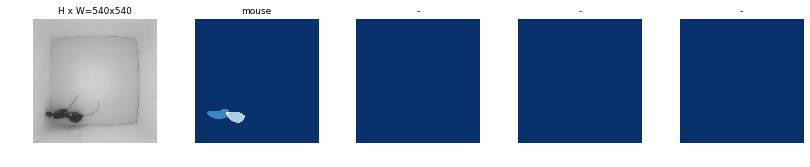

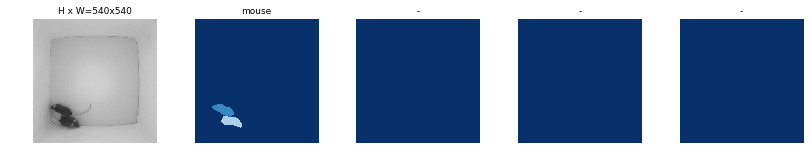

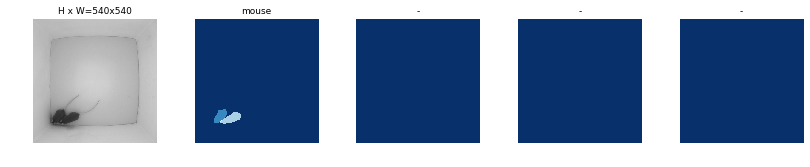

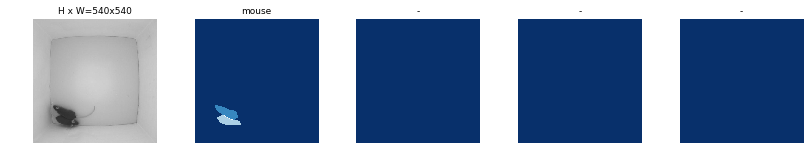

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Create model with initial coco weights

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Train the model

In [ ]:
print("Train network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            augmentation=augmentation,
            layers='heads')


Train network heads

Starting at epoch 0. LR=0.0005

Checkpoint Path: D:\tensorflow\mice_tracking_pipeline\mrcnn_models\mouse20200923T2342\mask_rcnn_mouse_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\vananh\AppData\Local\conda\conda\envs\markerless-mice-tracking-windowsGPU\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dens

Epoch 1/10
